<a href="https://colab.research.google.com/github/Areeb297/FellowshipAI_Change_Detection_Project/blob/main/FellowshipAI_Siamese_Networks_Areeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Satellite Imagery - Preprocessing

In [2]:
# Import packages
import os
import glob
import zipfile
import os, sys
from google.colab import drive
import torch
from PIL import Image
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import pickle
import cv2
import numpy as np
from torchvision.models import ResNet50_Weights
from torchvision import models
from torch.utils.data import random_split 
import copy  
from tqdm import tqdm
import datetime
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from torchvision import models
from torchvision.models import ResNet50_Weights



In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.getcwd()

'/content'

In [5]:
os.chdir('drive/MyDrive/My_workspace/LEVIR_CD')

In [6]:
images_train_A = sorted(os.listdir("train/A"))
images_train_B = sorted(os.listdir("train/B"))
images_train_mask = sorted(os.listdir("train/label"))

images_valid_A = sorted(os.listdir("val/A"))
images_valid_B = sorted(os.listdir("val/B"))
images_valid_mask = sorted(os.listdir("val/label"))

In [7]:
len(images_train_A)

445

In [8]:
len(images_valid_B)

64

In [9]:
try:
  os.mkdir('resized_images')
except:
  pass

In [10]:
def resize_image(path, files, filename):
  for i in range(len(files)):
    image_path = path + files[i]
    img = Image.open(image_path).resize((256, 256))
    img.save(os.getcwd() + '/resized_images/' + filename + '/' + files[i])

In [11]:
# resize_image(os.getcwd() + '/val/A/',  images_valid_A, filename='val/A')
# resize_image(os.getcwd() + '/val/B/',  images_valid_B, filename='val/B')
# resize_image(os.getcwd() + '/val/label/',  images_valid_mask, filename='val/label')


In [12]:
# resize_image(os.getcwd() + '/train/A/',  images_train_A, filename='train/A')
# resize_image(os.getcwd() + '/train/B/',  images_train_B, filename='train/B')
# resize_image(os.getcwd() + '/train/label/',  images_train_mask, filename='train/label')


In [13]:


# During training, the network would be fed pairs of images - one pre-disaster and one post-disaster - along with a label indicating if the images are similar or dissimilar. 
# The network would then learn to differentiate between the two types of pairs by adjusting its weights to minimize the loss function.

# Dataloader class for Siamese Network Approach

# In change detection for disaster data, similar pairs can be created by selecting two images of the same area before and after the disaster event. 
# These pairs would have similar features and provide positive samples for the Siamese network to learn from.

# Dissimilar pairs can be created by selecting two images of different areas before and after the disaster event or selecting one image before the event and one image after the event.
# These pairs would have different features and provide negative samples for the Siamese network to learn from.

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 transform: transforms = None, path = os.getcwd() + '/resized_images', type_data = '/train/', data_1=images_train_A, data_2=images_train_B, label=images_train_mask):

        # Get the images   
        self.old_data = path + type_data + 'A/'
        self.new_data = path + type_data +'B/'    
        self.mask_data = path + type_data + 'label/'
        self.type_data = type_data

        self.data_1 = data_1
        self.data_2 = data_2
        self.label = label

        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
            ])

    def __getitem__(self, index):


        if self.type_data == '/valid/':

          pre_construction = Image.open(self.old_data + self.data_1[index])
          pre_construction = np.array(pre_construction).resize((256, 256))


          post_construction = Image.open(self.new_data + self.data_2[index])
          post_construction = np.array(post_construction).resize((256, 256))


          label = Image.open(self.mask_data + self.label[index])
          label = np.array(label).resize((256, 256))

        else:

          pre_construction = Image.open(self.old_data + self.data_1[index])
          pre_construction = np.array(pre_construction)


          post_construction = Image.open(self.new_data + self.data_2[index])
          post_construction = np.array(post_construction)


          label = Image.open(self.mask_data + self.label[index])
          label = np.array(label)


        # if image.mode != 'RGB':
        pre_construction = self.transform(pre_construction).float()
        post_construction = self.transform(post_construction).float()
        # else:
        #   image = self.transform(image)
        return pre_construction, post_construction, torch.tensor(label)

    def __len__(self):
        return len(self.data_1)

In [14]:
train_data = ImageDataset()
train_data = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

valid_data = ImageDataset(type_data = '/val/', data_1=images_valid_A, data_2=images_valid_B, label=images_valid_mask)
valid_data = DataLoader(valid_data, batch_size=16, shuffle=False, drop_last=True)

In [15]:
# Early stopping
class EarlyStopping():
    """This class implements regularization during training using early stopping to prevent overfitting

    Args:
        patience (int): Number of times validation loss is allowed to increase in a row every epoch or so.
    """
    def __init__(self, patience=3):

        self.patience = patience
        self.counter = 0
        self.early_stop = False

    def __call__(self, previous_val_loss, curr_val_loss):
        """This magic method compares validation losses and adds to counter if loss increases, else resets the counter
        everytime an instance of the class is called
        
        Args:
            previous_val_loss (float): The validation loss in previous epoch
            curr_val_loss (float): The current validation loss
        """
        if curr_val_loss >= previous_val_loss:
            self.counter +=1
            if self.counter >= self.patience:  
                self.early_stop = True
        else:
            self.counter = 0



# def calculate_accuracy(model, data_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for i, (image1, image2, label) in enumerate(data_loader):
#             image1, image2, label = image1.to(device), image2.to(device), label.to(device)
#             output = model(image1, image2)
#             y_pred = output.flatten()


#             indices = np.nonzero(label.flatten())[0]
#             y_pred_mask = y_pred[indices]


#             correct += np.mean(y_pred_mask)

#             total += len(indices)

#         accuracy = correct / total
    
#     return accuracy

def pixel_wise_accuracy(output, label):
    output = (output > 0.5).float()
    correct = (output == label).float().sum()
    total = label.numel()
    accuracy = float(correct) / float(total)
    return accuracy

def validation(model, device, valid_loader, loss_function, threshold=0.5):
    """This function uses the CNN model to evaluate the loss on the validation data every certain epochs

    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        valid_loader (DataLoader): Validation data
        loss_function (torch.nn.Module): To evaluate loss of our predictions

    Returns:
        float: The average validation loss every epoch
    """
    hist_val_acc = []
    model.eval() # it tells your model that you are testing the model
    loss_total = 0
    hist_val_loss = []

    # Test validation data
    with torch.no_grad(): # Deactivate autograd, requires_grad is set to False, do not calculate gradients of new variables as we testing only
        print('\n')
        progress_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for _, (image1, image2, labels) in progress_bar:
            image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
            output = model(image1, image2)

            # if output.size() == torch.Size([16, 1, 256, 256]):
            # output = output.unsqueeze(0).resize(10, 1, 256, 256)
            labels = labels.unsqueeze(0).resize(16, 1, 256, 256)

            loss = loss_function(output.squeeze(0).float(), labels.float())


            acc = iou_accuracy(output, labels)
            # acc = pixel_wise_accuracy(output, labels)

            # y_pred = output.flatten()

            # indices = np.nonzero(labels.flatten())[0]
            # y_pred_mask = y_pred[indices]

            # accuracy = np.mean(y_pred_mask)

            hist_val_acc.append(acc)
            hist_val_loss.append(loss.item())
            progress_bar.set_description(f"Validation metrics: acc = {round(float(acc), 2)}. mean_val_acc = {round(np.mean(hist_val_acc), 2)}. mean_val_loss = {round(np.mean(hist_val_loss), 2)}")
            loss_total += loss.item()

    return loss_total / len(valid_loader), round(np.mean(hist_val_acc), 2)

In [16]:
def save_model(epoch, model, optimiser, val_acc, loss, weights_path):
    """This function changes model to cpu mode, saves the model weights, epoch we reached, optimizer details,
    validation accuracy and the training loss so we can restore any model if we want to explore and compare results later on.

    Args:
        epoch (int): Number of epoch we reached at the end of training
        model (torchvision.models): Model our training function returned
        optimiser (torch.optim): Optimiser we used to train
        val_acc (float): Average validation accuracy per epoch at the end of training
        loss (float): Average training loss per epoch 
        weights_path (str): The path to the weights folder contained in the model evaluation directory

    """
    
    model.to('cpu')
    torch.save({
        'epoch': epoch,
        'model_state_dict': copy.deepcopy(model.state_dict()),
        'optimizer_state_dict': optimiser.state_dict(),
        'validation_acc': val_acc,
        'training+loss': loss}, os.path.join(weights_path, f'epoch_{epoch}_results'))
    
    
import torch
import torch.nn.functional as F


# def contrastive_loss(output, label, margin=1.0):
#     """
#     Contrastive loss function for Siamese networks with a binary mask label.
    
#     Arguments:
#     output_1 -- output embeddings for first image, as a PyTorch tensor of shape (batch_size, embedding_dim)
#     output_2 -- output embeddings for second image, as a PyTorch tensor of shape (batch_size, embedding_dim)
#     label -- binary mask label, as a PyTorch tensor of shape (batch_size, height, width, channels)
#     margin -- margin used to separate the positive and negative pairs, as a float
    
#     Returns:
#     loss_contrastive -- contrastive loss value, as a PyTorch scalar tensor
#     """

#     # Compute Euclidean distance between the embeddings
#     # euclidean_distance = F.pairwise_distance(output_1, output_2, keepdim=True.view(1, 32)

#     # Compute contrastive loss
#     loss_contrastive = label * torch.pow(output, 2) + (1 - label) * torch.pow(torch.clamp(margin - output, min=0.0), 2)
#     loss_contrastive = torch.mean(loss_contrastive)

#     return loss_contrastive

# Sure, here's the PyTorch implementation of the Siamese network class for change detection:

# python

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import models


        

# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()


#         self.main = torch.nn.Sequential(
            
#             nn.Conv2d(3, 16, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout(p=0.2),
#             nn.Conv2d(16, 64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3),
#             nn.Dropout(p=0.2),
#             nn.ReLU()

#         )

#         self.fc = nn.Linear(256, 1)
        
#     def forward_once(self, x):
#         x = self.main(x)
#         return x

#     def forward(self, x1, x2):
#         out1 = self.forward_once(x1)
#         out2 = self.forward_once(x2)

#         dist = torch.abs(out1 - out2)
#         out = self.fc(dist)

#         return out

# class Classifier(nn.Module):
#     """SiamUnet_conc segmentation network."""

#     def __init__(self, input_nbr, label_nbr):
#         super(Classifier, self).__init__()

#         self.input_nbr = input_nbr

#         self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
#         self.bn11 = nn.BatchNorm2d(16)
#         self.do11 = nn.Dropout2d(p=0.2)
#         self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
#         self.bn12 = nn.BatchNorm2d(16)
#         self.do12 = nn.Dropout2d(p=0.2)

#         self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn21 = nn.BatchNorm2d(32)
#         self.do21 = nn.Dropout2d(p=0.2)
#         self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
#         self.bn22 = nn.BatchNorm2d(32)
#         self.do22 = nn.Dropout2d(p=0.2)

#         self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn31 = nn.BatchNorm2d(64)
#         self.do31 = nn.Dropout2d(p=0.2)
#         self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.bn32 = nn.BatchNorm2d(64)
#         self.do32 = nn.Dropout2d(p=0.2)
#         self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.bn33 = nn.BatchNorm2d(64)
#         self.do33 = nn.Dropout2d(p=0.2)

#         self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn41 = nn.BatchNorm2d(128)
#         self.do41 = nn.Dropout2d(p=0.2)
#         self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.bn42 = nn.BatchNorm2d(128)
#         self.do42 = nn.Dropout2d(p=0.2)
#         self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.bn43 = nn.BatchNorm2d(128)
#         self.do43 = nn.Dropout2d(p=0.2)

#         self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

#         self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
#         self.bn43d = nn.BatchNorm2d(128)
#         self.do43d = nn.Dropout2d(p=0.2)
#         self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
#         self.bn42d = nn.BatchNorm2d(128)
#         self.do42d = nn.Dropout2d(p=0.2)
#         self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
#         self.bn41d = nn.BatchNorm2d(64)
#         self.do41d = nn.Dropout2d(p=0.2)

#         self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

#         self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
#         self.bn33d = nn.BatchNorm2d(64)
#         self.do33d = nn.Dropout2d(p=0.2)
#         self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
#         self.bn32d = nn.BatchNorm2d(64)
#         self.do32d = nn.Dropout2d(p=0.2)
#         self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
#         self.bn31d = nn.BatchNorm2d(32)
#         self.do31d = nn.Dropout2d(p=0.2)

#         self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

#         self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
#         self.bn22d = nn.BatchNorm2d(32)
#         self.do22d = nn.Dropout2d(p=0.2)
#         self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
#         self.bn21d = nn.BatchNorm2d(16)
#         self.do21d = nn.Dropout2d(p=0.2)

#         self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

#         self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
#         self.bn12d = nn.BatchNorm2d(16)
#         self.do12d = nn.Dropout2d(p=0.2)
#         self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

#         self.sm = nn.LogSoftmax(dim=1)

#     def forward(self, x1, x2):

#         """Forward method."""
#         # Stage 1
#         x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
#         x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
#         x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


#         # Stage 2
#         x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
#         x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
#         x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

#         # Stage 3
#         x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
#         x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
#         x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
#         x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

#         # Stage 4
#         x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
#         x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
#         x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
#         x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)


#         ####################################################
#         # Stage 1
#         x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
#         x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
#         x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

#         # Stage 2
#         x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
#         x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
#         x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

#         # Stage 3
#         x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
#         x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
#         x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
#         x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

#         # Stage 4
#         x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
#         x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
#         x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
#         x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)


#         ####################################################
#         # Stage 4d
#         x4d = self.upconv4(x4p)
#         pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
#         x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
#         x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
#         x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
#         x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

#         # Stage 3d
#         x3d = self.upconv3(x41d)
#         pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
#         x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
#         x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
#         x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
#         x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

#         # Stage 2d
#         x2d = self.upconv2(x31d)
#         pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
#         x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
#         x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
#         x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

#         # Stage 1d
#         x1d = self.upconv1(x21d)
#         pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
#         x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
#         x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
#         x11d = self.conv11d(x12d)

#         #Softmax layer is embedded in the loss layer
#         #out = self.sm(x11d)
#         output = []
#         output.append(x11d)

#         return output






# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         # Load the ResNet50 model pre-trained on ImageNet
#         self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

                
#         for param in self.resnet.parameters(): 
#             param.requires_grad = False
#         # unfreeze last layer params
#         for param in self.resnet.fc.parameters():
#             param.requires_grad = True


#         # Replace the last layer with a 1x1 convolutional layer
#         # to reduce the number of channels to 3
#         self.resnet.fc = nn.Conv2d(2048, 3, kernel_size=1)
#         self.conv0 = nn.Conv2d(2048, 3, kernel_size=1)

        
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

#         self.fc1 = nn.Linear(1024, 256)

#         self.fc11 = nn.Linear(832, 256)

#         self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=30, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=52, stride=2)
#         self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=38, stride=2)


#         modules = list(self.resnet.children())[:-2]
#         self.resnet = nn.Sequential(*modules)
        
#     def forward_once(self, x):

#         x = self.resnet(x)
#         x = torch.sigmoid(self.conv0(x))

#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)

#         try:

#           x = x.view(-1, 1024)
#           x = F.relu(self.fc1(x))
#           x = x.view(256, 1, 1)

#           x = F.relu(self.deconv1(x))
#           x = F.relu(self.deconv2(x))
#           x = F.relu(self.deconv3(x))


#           x = x.view(1, 256, 256)

#         except:

#           x = x.view(-1, 832)
#           x = F.relu(self.fc11(x))
#           x = x.view(-1, 256, 1, 1)

#           x = F.relu(self.deconv1(x))
#           x = F.relu(self.deconv2(x))
#           x = F.relu(self.deconv3(x))


#           x = x.view(-1, 1, 256, 256)
 
        
#         return x

  
#     def forward(self, x1, x2):
#         output1 = self.forward_once(x1)
#         output2 = self.forward_once(x2)
#         return torch.abs(output1 - output2)



class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = nn.ReLU(inplace=True)(self.conv1(x))
        x = nn.ReLU(inplace=True)(self.conv2(x))
        return x


# class SiameseNetwork(nn.Module):
#     def __init__(self, base_model):
#         super(SiameseNetwork, self).__init__()
#         self.base_model = base_model
#         self.decoder = nn.Sequential(
#             UNetDecoder(2048, 1024),
#             UNetDecoder(1024, 512),
#             UNetDecoder(512, 256),
#             UNetDecoder(256, 128),
#             nn.Conv2d(128, 1, 1)
#         )

#     def forward(self, input1, input2):
#         output1 = self.base_model(input1)
#         output2 = self.base_model(input2)
#         x = torch.cat([output1, output2], dim=1)
#         x = self.decoder(x)
#         return x


# base_model = models.googlenet(pretrained=True)
# base_model = nn.Sequential(*list(base_model.children())[:-1])


class CustomClassifier(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        )


# class SiameseNetwork(nn.Module):
#     def __init__(self, base_model):
#         super(SiameseNetwork, self).__init__()
#         self.encoder = nn.Sequential(*list(base_model.children())[:-1])
#         self.up = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
#         self.decoder1 = UNetDecoder(2048, 1024)
#         self.decoder2 = UNetDecoder(1024, 512)
#         self.decoder3 = UNetDecoder(512, 256)
#         self.decoder4 = UNetDecoder(256, 128)
#         self.final_conv = nn.Conv2d(128, 1, kernel_size=1)

#     def forward(self, input1, input2):
#         output1 = self.encoder(input1)
#         output2 = self.encoder(input2)
        
#         output1 = self.up(output1)
#         output2 = self.up(output2)
        
#         x = torch.cat([output1, output2], dim=1)
        
#         x = self.decoder1(x, output1)
#         x = self.decoder2(x, output2)
#         x = self.decoder3(x, output1)
#         x = self.decoder4(x, output2)
        
#         x = self.final_conv(x)
#         return x


class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = nn.ReLU(inplace=True)(self.conv1(x))
        x = nn.ReLU(inplace=True)(self.conv2(x))
        return x


# Define Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # # Load the pre-trained ResNet50 model
        # self.resnet = models.resnet50(pretrained=True)

        # # Replace the fully connected layer with a new layer with the appropriate number of output channels
        # self.resnet.fc = nn.Linear(resnet.fc.in_features, 256 * 256)


        # Load the pre-trained DenseNet model
        # self.densenet = models.densenet121(pretrained=True)


        self.base_model = models.googlenet(pretrained=True)
        binary_classifier = CustomClassifier(in_channels=1024, out_channels=64)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        self.base_model.classifier = binary_classifier
      


        # self.decoder = nn.Sequential(
        #     UNetDecoder(2048, 1024),
        #     UNetDecoder(1024, 512),
        #     UNetDecoder(512, 256),
        #     UNetDecoder(256, 128),
        #     nn.Conv2d(128, 1, 1)
        # )

        # self.decoder1 = UNetDecoder(1024, 512)
        # self.decoder2 = UNetDecoder(1024, 256)
        # self.decoder3 = UNetDecoder(512, 128)
        # self.decoder4 = UNetDecoder(256, 64)
        self.final_conv = nn.Conv2d(64*2, 1, kernel_size=1)


        # self.deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)
        # binary_classifier = CustomClassifier(in_channels=2048, out_channels=1)
        # self.deeplab.classifier = binary_classifier

        # self.deeplab = models.segmentation.DeepLabV3(models.resnet.resnet50(pretrained=True), self.deeplab.classifier)
        # self.conv = nn.Conv2d(21, 1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)

        # self.batch_norm = nn.BatchNorm2d(num_features=1)


        # # Remove the fully connected layer from the model
        # modules = list(self.densenet.children())[:-1]
        # self.densenet = nn.Sequential(*modules)

        # # Add additional layers to transform the output tensor to an image
        # self.densenet.add_module('flatten', nn.Flatten())
            
        # # # Load pre-trained VGG16 model
        # # self.vgg_model = models.vgg16(pretrained=True)

        # # Remove the fully connected layer
        # # self.vgg_model.classifier = nn.Sequential(*list(self.vgg_model.classifier.children())[:-1])
        # # self.vgg_model.classifier.add_module('final_fc', nn.Linear(4096, 256 * 256))
        
        # # Make the VGG16 model layers trainable
        # for param in self.densenet.parameters():
        #     param.requires_grad = False

        # self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        # self.relu = nn.ReLU()
        # self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        self.dropout = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()

        # Add a convolutional layer to reduce the number of channels to 1
        # self.vgg_model.classifier.add_module('conv', nn.Conv2d(512, 1, kernel_size=1))


        # Define a deconvolution layer to upsample the feature maps
        # self.deconv_layer = nn.ConvTranspose2d(in_channels=4096, out_channels=1, kernel_size=32, stride=16, padding=8)
        # self.upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=5, stride=7, padding=1, output_padding=1)



    def forward(self, x1, x2):

        # features1 = self.deeplab(x1)['out']
        # features1 = self.batch_norm(self.conv(features1))
        # features1 = self.upsample(features1).view(features1.shape[0], 1, 256, 256)
        # features1 = self.relu(self.dropout(features1))



        # features2 = self.deeplab(x2)['out']
        # features2 = self.batch_norm(self.conv(features2))
        # features2 = self.upsample(features2).view(features2.shape[0], 1, 256, 256)
        # features2 = self.relu(self.dropout(features2))

        # Extract features from the two input images using the VGG16 model
        # features1 = self.densenet(x1)
        # features1 = self.relu(self.conv(features1.view(x1.shape[0], 1, 256, 256)))
        # features1 = self.leaky_relu(self.conv(features1.view(x1.shape[0], 1, 256, 256)))

      
        # features1 = self.upsample_layer(features1)
        # features1 = features1[:, :256, :256]

        # features1 = features1.view(1, 256, 256)
        # features1 = upsample_layer(features1)
        # features1 = features1.view(1, 256, 256)
        # features1 = self.upsample_layer(self.deconv_layer(features1))
        # features1 = features1.view(1, 256, 256)

        # features2 = self.densenet(x2)
        # features2 = features2.view(1, 512, 40)
        # upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=3, padding=1, output_padding=1)
        # features2 = self.upsample_layer(features2)
        # features2 = features2[:, :256, :256]
        
        # features2 = self.relu(self.conv(features2.view(x2.shape[0], 1, 256, 256)))
        # features2 = self.leaky_relu(self.conv(features2.view(x2.shape[0], 1, 256, 256)))
          # features2 = upsample_layer(features2)
        # features2 = features2.view(1, 256, 256)
          
        # features2 = self.upsample_layer(self.deconv_layer(features2))
        # features2 = features2.view(1, 256, 256)

        # Compute the absolute difference between the feature maps

        features1 = self.upsample(self.base_model(x1))
        features2 = self.upsample(self.base_model(x2))

        x = torch.cat([features1, features2], dim=1)
        
        # x = self.decoder1(x, features1)
        # x = self.decoder2(x, features2)
        # x = self.decoder3(x, features1)
        # x = self.decoder4(x, features2)
        
        x = self.final_conv(x)
        # diff = torch.abs(features1 - features2)

        # Upsample the feature maps using deconvolution
        # upsampled = self.deconv_layer(diff)

        # Apply a sigmoid activation function to obtain a pixel-wise binary mask
        # features1 = features1.view(features1.size()[0], 256, 256, 1)
        # features2 = features2.view(features2.size()[0], 256, 256, 1)
        # diff = F.pairwise_distance(features1, features2)
        mask = self.sigmoid(x)

        return mask


class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        input = torch.sigmoid(input)
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + self.smooth) /
                    (iflat.sum() + tflat.sum() + self.smooth))

def pixel_wise_accuracy(output, label):
    output = (output > 0.5).float()
    correct = (output == label).float().sum()
    total = label.numel()
    accuracy = float(correct) / float(total)
    return accuracy

def compute_pos_weight(data_loader):
    pos_count = 0
    neg_count = 0
    for x1, x2, label in data_loader:
        pos_count += torch.sum(label == 1)
        neg_count += torch.sum(label == 0)
    pos_weight = neg_count.float() / pos_count.float()
    return pos_weight

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance, label):
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        
    def forward(self, output, target):
        intersection = torch.sum(output * target)
        union = torch.sum(output) + torch.sum(target) - intersection
        iou = 1.0 - (intersection + 1.0) / (union + 1.0)
        return iou

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, output, target):
        loss = F.binary_cross_entropy_with_logits(output, target, pos_weight=self.pos_weight)
        return loss

def iou_accuracy(output, target):
    output = output.argmax(dim=1).float()  # Convert output to binary mask
    intersection = (output * target).sum()
    union = (output + target).sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add a small epsilon to avoid division by zero
    return np.abs(iou.item())

class PixelWiseBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(PixelWiseBinaryCrossEntropyLoss, self).__init__()
        
    def forward(self, output, label):
        loss = F.binary_cross_entropy(output, label, reduction='mean')
        return loss
    
def train(model, device, train_loader, valid_loader, epochs=1):

    """This function trains the CNN model, loops through the training data for a set number of epochs, 
    calculates predictions and loss, updates gradients and model parameters, prints loss in Tensorboard, saves the model every few epochs,
    and returns the trained CNN model.

    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        train_loader (DataLoader): Training data
        valid_loader (DataLoader): Validation data
        epochs (int): Number of times we loop through training data to improve our model parameters

    Returns:    
        model (Model): Trained CNN model
    """
     # Early stopping
    early_stopping = EarlyStopping(patience=9)
    last_loss = np.inf
    running_corrects = 0
    # start = time.time()
    ct = datetime.datetime.now()
            

    optimiser = torch.optim.Adam(model.parameters(), lr=3e-4)
    # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=2, gamma=0.6)
    # weight decay adds penalty to loss function, shrinks weights during backpropagation to prevent overfitting and exploding gradients
    batch_idx = 0
    total = 0 
    prev_val_acc = 0
    pos_weight = compute_pos_weight(train_loader)
    criterion = ContrastiveLoss()

    for epoch in range(epochs+1):
        print('\n')
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        hist_acc = [] 
        model.train()
        for _, (image1, image2, labels) in progress_bar:
            image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
            
        
            output = model(image1, image2)
            # zero the parameter gradients

            optimiser.zero_grad()

            # output = output.unsqueeze(0).resize(20, 1, 256, 256)
            labels = labels.unsqueeze(0).resize(32, 1, 256, 256)
            loss = criterion(output.float(), labels.float())
            # loss = contrastive_loss(output1, output2, labels, margin=1.0)
            loss.backward()

            # backward + optimize only if in training phase
            optimiser.step()
          

            batch_idx += 1
            acc = iou_accuracy(output, labels)
            # acc = pixel_wise_accuracy(output, labels)
            hist_acc.append(acc)
            progress_bar.set_description(f"Epoch = {epoch}/{epochs}. acc = {round(float(acc), 2)}. mean_train_acc = {round(np.mean(hist_acc), 2)}. Loss = {round(float(loss), 2)}")



        # exp_lr_scheduler.step()
        # Early stopping
        validation_loss_per_epoch, val_acc = validation(model, device, valid_loader, criterion) 

        early_stopping(last_loss, validation_loss_per_epoch)
        last_loss = validation_loss_per_epoch

                

        if early_stopping.early_stop:
            print("Early stopping invoked! We are at epoch:", epoch)
            torch.save(model, 'SM_LEVIR_model.pth')
            return model

    # torch.save(model.state_dict(), 'model_cnn')
    torch.save(model, 'SM_LEVIR_model.pth') # save the final model as well for comparison 
    print('End of epochs reached with best model saved in final_models')
    return model
        

In [17]:
from torch import nn
from torch.nn.modules.padding import ReplicationPad2d

model = SiameseNetwork()
# model = Classifier(3, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model_cnn = train(model, device, train_data, valid_data, epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Epoch = 0/10. acc = 0.0. mean_train_acc = 0.0. Loss = 1.53: 100%|██████████| 13/13 [01:31<00:00,  7.02s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.22: 100%|██████████| 4/4 [02:30<00:00, 37.56s/it]


Epoch = 1/10. acc = 0.0. mean_train_acc = 0.0. Loss = 1.07: 100%|██████████| 13/13 [00:43<00:00,  3.31s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.04: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch = 2/10. acc = 0.0. mean_train_acc = 0.0. Loss = 1.01: 100%|██████████| 13/13 [00:37<00:00,  2.89s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.02: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Epoch = 3/10. acc = 0.0. mean_train_acc = 0.0. Loss = 1.01: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch = 4/10. acc = 0.0. mean_train_acc = 0.0. Loss = 1.0: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Epoch = 5/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.99: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Epoch = 6/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.99: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Epoch = 7/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.99: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch = 8/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.99: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.02: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch = 9/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.99: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch = 10/10. acc = 0.0. mean_train_acc = 0.0. Loss = 0.96: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]


Validation metrics: acc = 0.0. mean_val_acc = 0.0. mean_val_loss = 1.01: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


End of epochs reached with best model saved in final_models


In [18]:

def iou_accuracy(output, target):
    output = output.argmax(dim=1).float()  # Convert output to binary mask
    intersection = (output * target).sum()
    union = (output + target).sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add a small epsilon to avoid division by zero
    return iou.item()

# Test the IoU accuracy function with random input tensors
output = torch.randn(1, 2, 256, 256)
target = torch.randn(1, 256, 256).round()
iou = iou_accuracy(output, target)
print(iou)

-0.000578650797251612


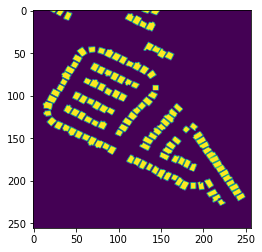

In [21]:
img = Image.open(os.getcwd() + '/resized_images/val/A/' + images_valid_A[19])
img_1 = np.array(img)


img = Image.open(os.getcwd() + '/resized_images/val/B/' + images_valid_B[19])
img_2 = np.array(img)

img_mask = Image.open(os.getcwd() + '/resized_images/val/label/' + images_valid_mask[19])
img_mask = np.array(img_mask)





plt.imshow(img_mask)

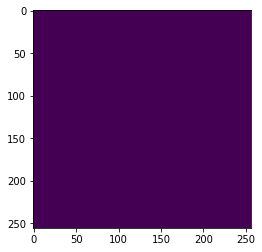

In [26]:
out = model_cnn(torch.tensor(img_1).float().to(device).resize(1, 3, 256, 256), torch.tensor(img_2).float().to(device).resize(1, 3, 256, 256))

out = out.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(out)

In [23]:
out

array([[ True,  True,  True, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [False, False, False, ...,  True, False,  True]])

In [17]:
import torch.nn as nn

# Define the convolutional layer
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)

# Test the convolutional layer with a random input tensor
x = torch.randn(1, 3, 256, 256)
output = conv(x)
print(output.shape)  # should be (1, 64, 256, 256)


torch.Size([1, 64, 256, 256])


In [25]:
x = torch.randn(14, 256, 256, 3)
y = torch.randn(14, 256, 256, 3)
F.pairwise_distance(x, y).size()

torch.Size([14, 256, 256])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Define Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Load pre-trained VGG16 model
        self.vgg_model = models.vgg16(pretrained=True)

        # Remove the fully connected layer
        self.vgg_model.classifier = nn.Sequential(*list(self.vgg_model.classifier.children())[:-1])
        
        # Make the VGG16 model layers trainable
        for param in self.vgg_model.parameters():
            param.requires_grad = False

        # Add a convolutional layer to reduce the number of channels to 1
        # self.vgg_model.classifier.add_module('conv', nn.Conv2d(512, 1, kernel_size=1))


        # Define a deconvolution layer to upsample the feature maps
        self.deconv_layer = nn.ConvTranspose2d(in_channels=4096, out_channels=1, kernel_size=32, stride=16, padding=8)
        self.upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=32, stride=16, padding=8)


    def forward(self, x1, x2):

        # Extract features from the two input images using the VGG16 model
        features1 = self.vgg_model(x1)
        features1 = features1.view(4096, 1, 1)
        features1 = self.upsample_layer(self.deconv_layer(features1))
        features1 = features1.view(1, 256, 256)

        features2 = self.vgg_model(x2)
        features2 = features2.view(4096, 1, 1)
        features2 = self.upsample_layer(self.deconv_layer(features2))
        features2 = features2.view(1, 256, 256)

        # Compute the absolute difference between the feature maps
        diff = torch.abs(features1 - features2)

        # Upsample the feature maps using deconvolution
        # upsampled = self.deconv_layer(diff)

        # Apply a sigmoid activation function to obtain a pixel-wise binary mask
        mask = torch.sigmoid(diff)

        return mask

In [ ]:
img = Image.open(os.getcwd() + '/resized_images/train/A/' + images_train_A[100])
img_1 = np.array(img)


img = Image.open(os.getcwd() + '/resized_images/train/B/' + images_train_B[100])
img_2 = np.array(img)

img_mask = Image.open(os.getcwd() + '/resized_images/train/label/' + images_train_mask[100])
img_mask = np.array(img_mask)

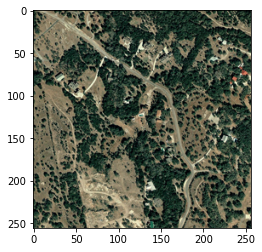

In [47]:
plt.imshow(img_1)

In [20]:
img = torch.rand(1, 512, 104, 1)

In [55]:
import torch.nn as nn

# Define a convolutional layer to downsample the input tensor
upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=5, stride=7, padding=1, output_padding=1)

# Define the input tensor
input_tensor = torch.rand(1, 1, 512, 40)

# Pass the input tensor through the convolutional layer
output_tensor = upsample_layer(input_tensor)

# Trim the output tensor to the desired size
output_tensor = output_tensor[:, :, :256, :256]
# Verify that the output tensor has the correct shape
print(output_tensor.shape)  # (1, 1, 256, 256)


torch.Size([1, 1, 256, 256])


In [73]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

# Define the pre-trained model to use
model = models.vgg16(pretrained=True)

# Remove the final fully-connected layer
modules = list(model.classifier.children())[:-1]
model.classifier = nn.Sequential(*modules)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

# Add a new fully connected layer to produce the desired output size
model.classifier.add_module('final_fc', nn.Linear(4096, 256 * 256))

# Reshape the output of the fully connected layer to the desired shape
model.classifier.add_module('reshape', Reshape(1, 256, 256))

# Test the modified model with a random input tensor
x = torch.randn(1, 3, 256, 256)
output = model(x)
print(output.shape)  # should be (1, 1, 256, 256)



torch.Size([10, 1, 256, 256])


In [23]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(1024, 1)

    def forward_once(self, x):
        x = self.base_model(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


base_model = models.googlenet(pretrained=True)
base_model = nn.Sequential(*list(base_model.children())[:-1])

siamese_network = SiameseNetwork(base_model)

class ChangeDetectionDataset(Dataset):
    def __init__(self, image_pairs, change_masks, transform=None):
        self.image_pairs = image_pairs
        self.change_masks = change_masks
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1, img2 = self.image_pairs[idx]
        change_mask = self.change_masks[idx]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, change_mask

# Set up dataset and data loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ChangeDetectionDataset(image_pairs, change_masks, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Set up the optimizer and loss function
optimizer = optim.Adam(siamese_network.parameters(), lr=1e-4)
criterion = ContrastiveLoss()

# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "



In [35]:
class CustomClassifier(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        )

class SimpleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, upsample_scale):
        super(SimpleDecoder, self).__init__()
        self.up = nn.Upsample(scale_factor=upsample_scale, mode='bilinear', align_corners=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x
        
# Define Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # # Load the pre-trained ResNet50 model
        # self.resnet = models.resnet50(pretrained=True)

        # # Replace the fully connected layer with a new layer with the appropriate number of output channels
        # self.resnet.fc = nn.Linear(resnet.fc.in_features, 256 * 256)


        # Load the pre-trained DenseNet model
        # self.densenet = models.densenet121(pretrained=True)


        self.base_model = models.googlenet(pretrained=True)
        binary_classifier = CustomClassifier(in_channels=1024, out_channels=1)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        self.base_model.classifier = binary_classifier
      


        
        # self.decoder = nn.Sequential(
        #     UNetDecoder(2048, 1024),
        #     UNetDecoder(1024, 512),
        #     UNetDecoder(512, 256),
        #     UNetDecoder(256, 128),
        #     nn.Conv2d(128, 1, 1)
        # )

        self.decoder1 = UNetDecoder(2, 512)
        self.decoder2 = UNetDecoder(1024, 256)
        self.decoder3 = UNetDecoder(512, 128)
        self.decoder4 = UNetDecoder(256, 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


        # self.deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)
        # binary_classifier = CustomClassifier(in_channels=2048, out_channels=1)
        # self.deeplab.classifier = binary_classifier

        # self.deeplab = models.segmentation.DeepLabV3(models.resnet.resnet50(pretrained=True), self.deeplab.classifier)
        # self.conv = nn.Conv2d(21, 1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)

        # self.batch_norm = nn.BatchNorm2d(num_features=1)


        # # Remove the fully connected layer from the model
        # modules = list(self.densenet.children())[:-1]
        # self.densenet = nn.Sequential(*modules)

        # # Add additional layers to transform the output tensor to an image
        # self.densenet.add_module('flatten', nn.Flatten())
            
        # # # Load pre-trained VGG16 model
        # # self.vgg_model = models.vgg16(pretrained=True)

        # # Remove the fully connected layer
        # # self.vgg_model.classifier = nn.Sequential(*list(self.vgg_model.classifier.children())[:-1])
        # # self.vgg_model.classifier.add_module('final_fc', nn.Linear(4096, 256 * 256))
        
        # # Make the VGG16 model layers trainable
        # for param in self.densenet.parameters():
        #     param.requires_grad = False

        # self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        # self.relu = nn.ReLU()
        # self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        self.dropout = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()

        # Add a convolutional layer to reduce the number of channels to 1
        # self.vgg_model.classifier.add_module('conv', nn.Conv2d(512, 1, kernel_size=1))


        # Define a deconvolution layer to upsample the feature maps
        # self.deconv_layer = nn.ConvTranspose2d(in_channels=4096, out_channels=1, kernel_size=32, stride=16, padding=8)
        # self.upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=5, stride=7, padding=1, output_padding=1)



    def forward(self, x1, x2):

        # features1 = self.deeplab(x1)['out']
        # features1 = self.batch_norm(self.conv(features1))
        # features1 = self.upsample(features1).view(features1.shape[0], 1, 256, 256)
        # features1 = self.relu(self.dropout(features1))



        # features2 = self.deeplab(x2)['out']
        # features2 = self.batch_norm(self.conv(features2))
        # features2 = self.upsample(features2).view(features2.shape[0], 1, 256, 256)
        # features2 = self.relu(self.dropout(features2))

        # Extract features from the two input images using the VGG16 model
        # features1 = self.densenet(x1)
        # features1 = self.relu(self.conv(features1.view(x1.shape[0], 1, 256, 256)))
        # features1 = self.leaky_relu(self.conv(features1.view(x1.shape[0], 1, 256, 256)))

      
        # features1 = self.upsample_layer(features1)
        # features1 = features1[:, :256, :256]

        # features1 = features1.view(1, 256, 256)
        # features1 = upsample_layer(features1)
        # features1 = features1.view(1, 256, 256)
        # features1 = self.upsample_layer(self.deconv_layer(features1))
        # features1 = features1.view(1, 256, 256)

        # features2 = self.densenet(x2)
        # features2 = features2.view(1, 512, 40)
        # upsample_layer = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=3, padding=1, output_padding=1)
        # features2 = self.upsample_layer(features2)
        # features2 = features2[:, :256, :256]
        
        # features2 = self.relu(self.conv(features2.view(x2.shape[0], 1, 256, 256)))
        # features2 = self.leaky_relu(self.conv(features2.view(x2.shape[0], 1, 256, 256)))
          # features2 = upsample_layer(features2)
        # features2 = features2.view(1, 256, 256)
          
        # features2 = self.upsample_layer(self.deconv_layer(features2))
        # features2 = features2.view(1, 256, 256)

        # Compute the absolute difference between the feature maps

        features1 = self.base_model(x1)
        features2 = self.upsample(self.base_model(x2))

        x = torch.cat([features1, features2], dim=1)
        
        x = self.decoder1(x, features1)
        x = self.decoder2(x, features2)
        x = self.decoder3(x, features1)
        x = self.decoder4(x, features2)
        
        x = self.final_conv(x)
        # diff = torch.abs(features1 - features2)

        # Upsample the feature maps using deconvolution
        # upsampled = self.deconv_layer(diff)

        # Apply a sigmoid activation function to obtain a pixel-wise binary mask
        # features1 = features1.view(features1.size()[0], 256, 256, 1)
        # features2 = features2.view(features2.size()[0], 256, 256, 1)
        # diff = F.pairwise_distance(features1, features2)
        mask = self.sigmoid(x)

        return mask

In [26]:
model = models.googlenet(pretrained=True)
model(torch.randn(14, 3, 256, 256)).size()

torch.Size([14, 1000])

In [ ]:
model = SiameseNetwork()
x = torch.randn(14, 3, 256, 256)
y = torch.randn(14, 3, 256, 256)
model(x, y).size()

In [28]:
torch.tensor(img_1).unsqueeze(0).resize(1, 3, 256, 256)

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[[[  4,  17,  13,  ...,   7,   6,   8],
          [ 18,  21,  33,  ...,  25,  13,  26],
          [ 20,  51,  70,  ...,  43,  64,  57],
          ...,
          [ 39,  28,  18,  ...,  51,  77,  86],
          [ 73,  57,  72,  ...,  26,  42,  44],
          [ 16,  41,  29,  ...,  38,  23,  36]],

         [[ 60,  49,  36,  ...,  44,  47,  53],
          [ 37,  68,  84,  ...,  28,  39,  31],
          [ 10,  35,  23,  ...,  36,  28,  13],
          ...,
          [100,  52,  74,  ...,  79,  95,  69],
          [ 15,  41,  35,  ...,  50,  43, 122],
          [108,  86, 125,  ...,  47, 102, 103]],

         [[ 91,  84,  92,  ..., 119, 130, 102],
          [ 46,  63,  42,  ...,   1,   6,  87],
          [ 81,  68, 132,  ...,   4,   9,   9],
          ...,
          [ 41,  73,  47,  ..., 101,  88, 107],
          [102,  84, 157,  ...,  56, 105, 109],
          [ 87, 175, 166,  ...,  29,  56,  46]]]], dtype=torch.uint8)

In [52]:
model = SiameseNetwork()
output = model(torch.tensor(img_1).unsqueeze(0).float().resize(1, 3, 256, 256), torch.tensor(img_2).unsqueeze(0).float().resize(1, 3, 256, 256))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [53]:
output.size()

torch.Size([1, 1, 256, 256])

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Replace the fully connected layer with a new layer with the appropriate number of output channels
num_classes = 10  # Replace with the number of classes for your task
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Test the modified model with a random input tensor
x = torch.randn(1, 3, 224, 224)
output = resnet(x)
print(output.shape)  # should be (1, 10)


torch.Size([1, 10])


In [38]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained DenseNet model
densenet = models.densenet121(pretrained=True)

# Remove the fully connected layer from the model
modules = list(densenet.children())[:-1]
densenet = nn.Sequential(*modules)

# Add additional layers to transform the output tensor to an image
densenet.add_module('flatten', nn.Flatten())
densenet.add_module('ReLU', nn.ReLU())
# densenet.add_module('relu', nn.ReLU())
# densenet.add_module('conv_transpose', nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1))
# densenet.add_module('sigmoid', nn.Sigmoid())

# Test the modified model with a random input tensor
x = torch.randn(1, 3, 256, 256)
output = densenet(x)
print(output.resize(1, 256, 256).size())


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 256, 256])


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [63]:
deeplab_backbone = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)
class CustomClassifier(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        )

binary_classifier = CustomClassifier(in_channels=2048, out_channels=1)
deeplab_backbone.classifier = binary_classifier


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
deeplab_binary_model = deeplab_backbone

In [57]:
class CustomDeepLabBinary(nn.Module):
    def __init__(self, deeplab_model, output_size=(256, 256)):
        super(CustomDeepLabBinary, self).__init__()
        self.deeplab = deeplab_model
        self.output_size = output_size
        self.conv = nn.Conv2d(21, 1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(size=output_size, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.deeplab(x)
        x = self.conv(x)
        x = self.upsample(x)
        return x


In [58]:
output_size = (256, 256)
custom_binary_model = CustomDeepLabBinary(deeplab_model, output_size)


In [65]:
model = deeplab_binary_model(torch.randn(1, 3, 256, 256))


In [72]:
model['out'].size()

torch.Size([1, 1, 256, 256])